<a href="https://colab.research.google.com/github/Jaesu26/dacon-point-of-interest-category-classification/blob/main/2022-09-28-%EA%B4%80%EA%B4%91%EC%A7%80%EC%A0%90%EC%A0%95%EB%B3%B4-%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 관광데이터 AI 경진대회

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
# !pip install albumentations==1.2.1
# !pip install adabelief-pytorch
# !pip install timm
# !pip install ttach

In [3]:
!pip install transformers==4.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.2 MB/s 
     |████████████████████████████████| 880 kB 44.9 MB/s 
     |████████████████████████████████| 3.3 MB 53.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=83d6791cdca0dd634d17ba53fa92e766a4998a97bb64763be2551835c735d6a8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


`-` 런타임 재시작

## 데이터 불러오기

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
import random
import cv2
import re
import os
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

from typing import Callable, Dict, Sequence, List, Optional, Tuple, Union
from numpy.typing import NDArray
from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [6]:
%cd  '/content/drive/MyDrive/Colab Notebooks/관광지점정보-카테고리-분류/Data'

/content/drive/MyDrive/Colab Notebooks/관광지점정보-카테고리-분류/Data


In [7]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/관광지점정보-카테고리-분류/Data/open.zip'

- 데이터 불러오기

In [8]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv') 

In [9]:
target = df['cat3'].values  ## 최종적으로 예측해야할 카테고리

`-` target 라벨 인코딩

In [10]:
le = LabelEncoder()
target = le.fit_transform(target)

- 하이퍼파라미터 (텍스트)

In [11]:
MODEL_NAME = {'electra':'kykim/electra-kor-base', 'funnel':'kykim/funnel-kor-base'} 
MODEL_TYPE = 'electra'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_TYPE}_default_weight.pt' 
SAVE_PATH = './weight'
NUM_CLASSES = len(np.unique(target))  ## 128개
NUM_FOLDS = 5
NUM_EPOCHS = 30
MAX_LEN = 200  
BATCH_SIZE = 64
LEARNING_RATE = 5e-5
LABEL_SMOOTHING = 0.1  ## 잘못 라벨링된 데이터가 존재
SEED = 2022

- 가중치 저장폴더

In [12]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [13]:
create_folder(SAVE_PATH)

## 시각화

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

### 라벨

In [ ]:
df.groupby(['cat1', 'cat2']).agg({'cat3':[np.unique, lambda x: len(np.unique(x)), len]})

cat3  \
                                                                unique   
cat1         cat2                                                        
레포츠          레포츠소개                                               수상레포츠   
             복합 레포츠                                             복합 레포츠   
             수상 레포츠  [래프팅, 민물낚시, 바다낚시, 수영, 스노쿨링/스킨스쿠버다이빙, 요트, 윈드서핑/...   
             육상 레포츠  [ATV, MTB, 골프, 번지점프, 빙벽등반, 사격장, 수련시설, 스케이트, 스키...   
             항공 레포츠                             [스카이다이빙, 헹글라이딩/패러글라이딩]   
쇼핑           쇼핑             [5일장, 공예,공방, 면세점, 백화점, 상설시장, 전문상가, 특산물판매점]   
숙박           숙박시설    [게스트하우스, 모텔, 민박, 서비스드레지던스, 유스호스텔, 콘도미니엄, 펜션, 한...   
음식           음식점           [바/까페, 서양식, 일식, 중식, 채식전문점, 클럽, 패밀리레스토랑, 한식]   
인문(문화/예술/역사) 건축/조형물             [기념탑/기념비/전망대, 다리/대교, 동상, 분수, 유명건물, 터널]   
             공연/행사      [기타행사, 대중콘서트, 뮤지컬, 박람회, 연극, 전통공연, 컨벤션, 클래식음악회]   
             문화시설    [공연장, 기념관, 대형서점, 도서관, 문화원, 문화전수시설, 미술관/화랑, 박물관...   
             산업관광지                                      [기타, 발전소, 식음료]   
             역사관광지   [고궁, 고택, 문, 민속마을, 사찰, 생가, 성, 안보관광, 유적지/사적지, 종교성지]   
             체험관광지                             [농.산.어촌 체험, 이색거리, 이색체험]   
             축제                                         [문화관광축제, 일반축제]   
             휴양관광지   [공원, 관광단지, 온천/욕장/스파, 유람선/잠수함관광, 유원지, 이색찜질방, 테마...   
자연           관광자원                                       [기암괴석, 희귀동.식물]   
             자연관광지   [강, 계곡, 국립공원, 군립공원, 도립공원, 동굴, 등대, 산, 섬, 수목원, 약...   

                                      
                    <lambda_0>   len  
cat1         cat2                     
레포츠          레포츠소개           1    11  
             복합 레포츠          1    24  
             수상 레포츠          8   277  
             육상 레포츠         19  2288  
             항공 레포츠          2    11  
쇼핑           쇼핑              7   696  
숙박           숙박시설            9  1434  
음식           음식점             8  4912  
인문(문화/예술/역사) 건축/조형물          6   328  
             공연/행사           8   139  
             문화시설           13  1220  
             산업관광지           3    93  
             역사관광지          10  1571  
             체험관광지           3   805  
             축제              2   569  
             휴양관광지           8   889  
자연           관광자원            2   141  
             자연관광지          18  1578

`-` 라벨 불균형이 매우 심하다

`-` 항공 레포츠는 범주 2개에 총 11개의 데이터가 있는 반면, 음식점은 범주 8개에 총 4912개의 데이터가 있다

`-` 하지만 평가산식은 `weighted f1 score`이므로 적은 클래스의 카테고리는 내다 버려도 좋은 점수를 얻을 수 있다

`-` 그런데 train과 test의 분포가 다르다면?......

`-` 무작위로 샘플링했다면 둘의 분포가 비슷할 것이다

- 카테고리 3

In [ ]:
df['cat3'].value_counts().describe()

count     128.000000
mean      132.703125
std       349.099299
min         2.000000
25%        11.000000
50%        36.000000
75%       121.500000
max      3438.000000
Name: cat3, dtype: float64

`-` 데이터가 2개 뿐인 범주가 존재한다

`-` 3438개로 가장 많은 데이터를 가진 범주는 한식이다

`-` 한식 카테고리를 잘 맞춰야 좋은 점수를 받을 수 있다

`-` 적은 데이터를 가진 범주를 드랍하는 것도 고려해보자

In [ ]:
df['cat3'].value_counts().to_dict()

{'한식': 3438,
 '야영장,오토캠핑장': 1558,
 '바/까페': 785,
 '유적지/사적지': 622,
 '일반축제': 549,
 '사찰': 495,
 '이색거리': 467,
 '펜션': 445,
 '한옥스테이': 404,
 '모텔': 340,
 '농.산.어촌 체험': 332,
 '박물관': 310,
 '공원': 271,
 '상설시장': 270,
 '트래킹': 246,
 '전시관': 243,
 '산': 239,
 '서양식': 226,
 '유원지': 211,
 '중식': 209,
 '자연생태관광지': 207,
 '해수욕장': 207,
 '미술관/화랑': 204,
 '골프': 179,
 '전문상가': 173,
 '테마공원': 172,
 '5일장': 165,
 '계곡': 160,
 '일식': 151,
 '기념탑/기념비/전망대': 148,
 '항구/포구': 134,
 '관광단지': 126,
 '공연장': 120,
 '민물낚시': 119,
 '자연휴양림': 118,
 '문화원': 113,
 '섬': 111,
 '유명건물': 105,
 '강': 104,
 '수목원': 95,
 '수련시설': 95,
 '도서관': 92,
 '고택': 92,
 '희귀동.식물': 88,
 '성': 85,
 '게스트하우스': 83,
 '기타': 79,
 '민속마을': 76,
 '기타행사': 71,
 '종교성지': 65,
 '기념관': 64,
 '패밀리레스토랑': 61,
 '스키(보드) 렌탈샵': 60,
 '바다낚시': 57,
 '홈스테이': 57,
 '기암괴석': 53,
 '온천/욕장/스파': 53,
 '생가': 43,
 '다리/대교': 41,
 '공예,공방': 41,
 '폭포': 40,
 '민박': 39,
 '특산물판매점': 37,
 '채식전문점': 36,
 '고궁': 36,
 '자동차경주': 35,
 '콘도미니엄': 34,
 '안보관광': 34,
 '호수': 30,
 '유람선/잠수함관광': 30,
 '박람회': 29,
 '수영': 27,
 '윈드서핑/제트스키': 27,
 '썰매장'

### 이미지

`-` 안타깝게도 이미지의 크기가 모두 다르다

In [ ]:
image_w = []
image_h = []
for img_path in tqdm(df['img_path'].values):
    image = cv2.imread(img_path)
    h, w, _ = image.shape
    image_w.append(w)
    image_h.append(h)

  0%|          | 0/16986 [00:00<?, ?it/s]

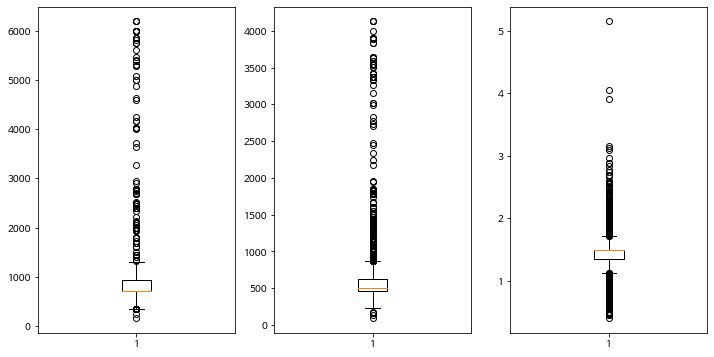

In [ ]:
image_w = np.array(image_w)
image_h = np.array(image_h)
image_ratio = image_w / image_h  ## 가로 / 세로
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(image_w)
ax2.boxplot(image_h)
ax3.boxplot(image_ratio)
plt.show()

`-` 대부분의 이미지는 가로가 세로보다 더 길다

- 가로로 가장 긴 이미지

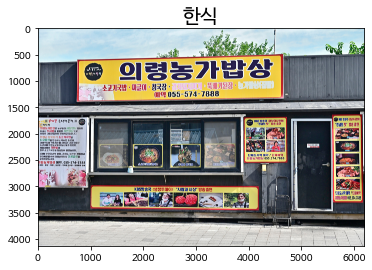

In [ ]:
img_path = df['img_path'].values[np.argmax(image_w)]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(df['cat3'].values[np.argmax(image_w)], fontsize=20)
plt.show()

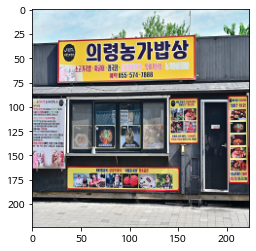

In [ ]:
plt.imshow(cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_AREA))

- 가로로 가장 짧은 이미지

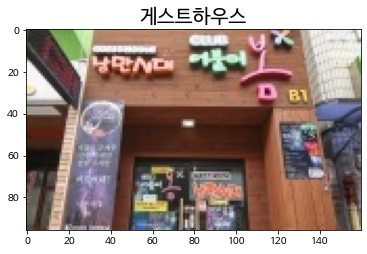

In [ ]:
img_path = df['img_path'].values[np.argmin(image_w)]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(df['cat3'].values[np.argmin(image_w)], fontsize=20)
plt.show()

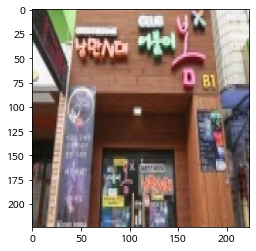

In [ ]:
plt.imshow(cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_AREA))

- 세로로 가장 긴 이미지

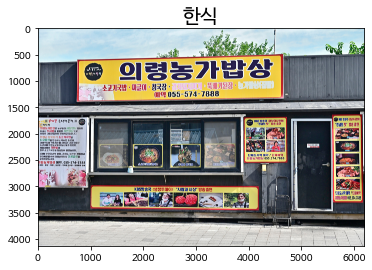

In [ ]:
img_path = df['img_path'].values[np.argmax(image_h)]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(df['cat3'].values[np.argmax(image_h)], fontsize=20)
plt.show()

- 세로로 가장 짧은 이미지

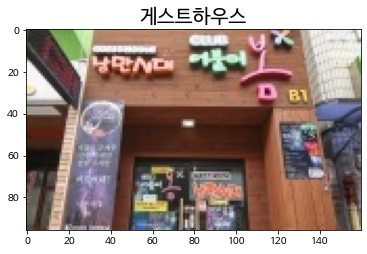

In [ ]:
img_path = df['img_path'].values[np.argmin(image_h)]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(df['cat3'].values[np.argmin(image_h)], fontsize=20)
plt.show()

- $\cfrac{가로}{세로}$ 값이 가장 큰 이미지

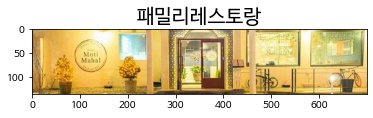

In [ ]:
img_path = df['img_path'].values[np.argmax(image_ratio)]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(df['cat3'].values[np.argmax(image_ratio)], fontsize=20)
plt.show()

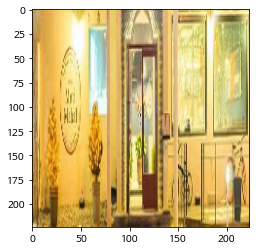

In [ ]:
plt.imshow(cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_AREA))

- $\cfrac{가로}{세로}$ 값이 가장 작은 이미지

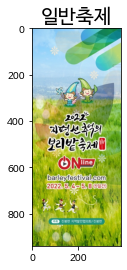

In [ ]:
img_path = df['img_path'].values[np.argmin(image_ratio)]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(df['cat3'].values[np.argmin(image_ratio)], fontsize=20)
plt.show()

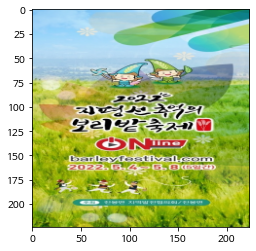

In [ ]:
plt.imshow(cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_AREA))

### 텍스트

In [ ]:
df['overview'].str.len().describe()

count    16986.000000
mean       334.291711
std        283.720345
min          7.000000
25%        168.250000
50%        274.000000
75%        415.000000
max       7972.000000
Name: overview, dtype: float64

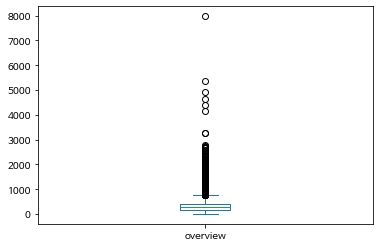

In [ ]:
df['overview'].str.len().plot.box()

`-` 공공기관 데이터라 그런지 글의 띄어쓰기, 맞춤법 상태가 좋다

`-` html 태그 제거해야 함

`-` yyyy년 mm월 dd일, n층, $m^2$ 제거해야 함

`-` 숫자 단어 제거하면 안되는 경우: 5일장, + MTB 

`-` 제거하는게 훨씬 이득인 듯 (5일장은 오일장으로 바꾸자)

`-` 개요가 8천글자......

`-` 굳이 설명을 다 읽을 필요가 있을까?

`-` 일반적으로 주요 내용을 앞에서 설명하고 뒤의 설명은 부가적이다

`-` 그러면 굳이 개요 전부를 읽지말고 중간 부근까지만 읽어보자

`-` 짧은 글은 전체를 다 읽고 긴 글은 다 읽지 말자

`-` 문장은 마침표를 기준으로 구분되어 있다

`-` cutting할 때는 마침표 위치를 찾고 원하는 지점에 가장 가까운 마침표를 기준으로 잘라내자

`-` **적은 클래스를 오버샘플링 해보자** (적어도 5개는 만들자)

`-` 내가 임의로 텍스트를 살짝 변경하면 될 듯

`-` 아니면 마침표를 기준으로 문장을 추출한 후 문장을 랜덤셔플하여 텍스트를 생성해보자

`-` 또한, 임의의 문장을 드랍할 수 도 있다 (단 2문장 이상일 때만)

`-` agumentation class를 만들자 (마침표를 기준으로 문장 추출, 랜덤 셔플, 드랍)

`-` 변형을 추가하되 소수 클래스는 미리 데이터를 증강해두자 (최소 5개)

`-` 미리 데이터 증강하면 오버피팅 될 듯 (증강 방법이 새로운 단어나 문장을 추가하는게 아님)

#### 소수 클래스 개요 확인

`-` 몇개 확인해봤는데 맞추기 쉽거나 거의 못 맞추거나 둘 중 하나인 듯하다

In [ ]:
minor_classes = df['cat3'].value_counts()[-30:].reset_index()['index'].to_numpy()

- 컨벤션센터

`-` 컨벤션이 있고 컨벤션센터가 있다 ㅋㅋㅋ

`-` 범주가 컨벤션센터인 텍스트는 11개이고 그 중 2개 텍스트에는 컨벤션센터라는 단어가 들어있지 않다

- 식음료

`-` 음식 + 관광지

`-` 주류(와인)이 많이 언급됨

- 클럽

`-` 음식점으로 분류됨......

#### 단어 대체

`-` 단어를 다른 단어로 대체할 필요가 있음

`-` 예컨대 cate -> 카페

`-` 까페 -> 카페

`-` ATV -> 오토바이

## 데이터 전처리

`-` 모델 학습을 수월하게 하기 위해 이미지 크기를 $224 \times 224$로 만들어서 저장하겠다

`-` 위에서 극단적인 형태의 이미지를 resize 하고 시각화했을 때 문제가 없었으니 다른 이미지도 resize 했을 때 문제 없을 것이다

- 이미지

In [ ]:
# create_folder('./image-array')

In [ ]:
def save_images(image_paths: NDArray, path: str) -> None:
    df = pd.DataFrame([])
    for i, image_path in tqdm(enumerate(image_paths)):
        ## image 불러온 후 (224, 224) 크기로 resize and flatten
        image = cv2.imread(image_path)
        image = cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_AREA)
        vector = image.reshape(-1)  ## 224*224*3

        ## image array를 pandas DataFrame으로 변경 후 feather 파일로 저장
        df[f'X{i}'] = vector
    df.to_feather(path)

In [ ]:
# save_images(df['img_path'].values, path='./image-array/train.feather')

In [ ]:
# save_images(test['img_path'].values, path='./image-array/test.feather')

- 텍스트

`-` 한글만 봐도 관광지점 카테고리를 구분할 수 있을 것 같다

In [14]:
minor2major_dict = {'museum':'박물관',
                    'cafe':'카페',
                    'food':'음식',
                    'dance':'댄스',
                    'forest':'숲',
                    'sea':'바다',
                    'tea':'녹차',
                    'cinema':'영화관',
                    'cart':'카트',
                    'art':'미술',
                    'astronomical':'천문학',
                    'bmw':'독일자동차',
                    'convention':'컨벤션',
                    'hotel':'호텔',
                    'handcraft':'수예',
                    'lake':'호수',
                    'gift':'선물',
                    'media':'미디어',
                    'motel':'모텔',
                    'coffe':'커피',
                    'shopping':'쇼핑',
                    'sea':'바다',
                    'gallery':'갤러리',
                    'megabox':'영화관',
                    'wifi':'와이파이',
                    'speed':'스피드',
                    'mountain':'산',
                    'grand':'그랜드',
                    'summer':'여름',
                    'garden':'정원',
                    'flower':'꽃',
                    'brand':'브랜드',
                    'east':'동쪽',
                    'west':'서쪽',
                    'north':'북쪽',
                    'south':'남쪽',
                    'coex':'코엑스',
                    'bread':'빵',
                    'bungee':'번지',
                    'bexco':'컨벤션센터',
                    'ceco':'컨벤션센터',
                    'kintex':'컨벤션센터',
                    'apap':'미술관',
                    'apple':'사과',
                    'bbq':'치킨',
                    'biff':'영화제',
                    'piff':'영화제',
                    'film':'영화',
                    'central':'센트럴',
                    'clock':'외투',
                    'car':'자동차',
                    'cozy':'아늑한',
                    'cucina':'주방',
                    'drive':'드라이브',
                    'european':'유럽',
                    'chocolate':'초콜릿',
                    'dharma':'종교',
                    'in':'안에',
                    'internation':'국제적인',
                    'jacqueline':'모델',
                    'korea':'한국',
                    'korean':'한국어',
                    'koroviar':'스파',
                    'ymca':'종교',
                    'famous':'유명한',
                    'team':'팀',
                    'edm':'댄스 뮤직',
                    'haccap':'식약처 인증',
                    'haccp':'식약처 인증',
                    'sns':'소셜',
                    'vip':'귀빈',
                    'atm':'현금인출기',
                    'dmz':'비무장',
                    'ebs':'교육',
                    'kbs':'방송국',
                    'sbs':'방송국',
                    'jtbc':'방송국',
                    'ktx':'고속열차',
                    'esg':'환경',
                    'atv':'오토바이',
                    'mtb':'산악자전거',
                    '5일장':'오일장',
                    '까페':'카페',
                    '해썹':'식약처 인증',}

In [15]:
def clean_texts(texts: Sequence[str]) -> NDArray: 
    new_texts = [] 
    for text in texts: 
        text = text.lower()
        text = re.sub(r'\w*\d\w*', '', text)  ## 숫자 단어 제거
        text = re.sub(r"[^\uAC00-\uD7A3\s\.]", ' ', text)  ## 한글 음절, 띄어쓰기, 마침표 제외하고 모두 삭제
        text = re.sub(r'\s+', ' ', text)  ## extra space 제거
        text = text.strip()
        new_texts.append(text) 
    new_texts = np.array(new_texts)
    return new_texts

In [16]:
def minor2major(texts: Sequence[str], minor2major_dict: Dict[str, str]) -> NDArray:
    new_texts = []
    for text in texts:
        for minor, major in minor2major_dict.items():
            text = text.replace(minor, major)
        new_texts.append(text)

    new_texts = np.array(new_texts)
    return new_texts

In [17]:
def cut_texts(texts: Sequence[str], max_len: int = 550) -> NDArray:
    new_texts = []
    for text in texts:
        full_stop_idx = [idx for idx, char in enumerate(text) if char == '.']
        if full_stop_idx:
            full_stop_idx = np.array(full_stop_idx)
            end_idx = full_stop_idx[full_stop_idx < max_len][-1]
        else:
            end_idx = len(text)
        new_texts.append(text[:end_idx])
    new_texts = np.array(new_texts)
    return new_texts

In [18]:
def remove_fullstops(texts: Sequence[str]) ->  NDArray:
    new_texts = []
    for text in texts:
        text = re.sub(r'\.', '', text)    ## 마침표 제거 (word1~.~word2 -> word1~~word2)
        text = re.sub(r'\s+', ' ', text)  ## extra space 제거 (word1~~word2 -> word1~word2)
        text = text.strip()     
        new_texts.append(text)
    new_texts = np.array(new_texts)
    return new_texts

### 텍스트 길이와 토큰 길이

In [ ]:
import torch
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME[MODEL_TYPE])  

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

### cut text 적용 X

In [ ]:
train_texts = df['overview'].values
train_texts = minor2major(train_texts, minor2major_dict)
train_texts = clean_texts(train_texts)
# train_texts = cut_texts(train_texts)
train_texts = remove_fullstops(train_texts)

- 텍스트 길이

In [ ]:
texts_len = list(map(len, train_texts))

25%:  151.0
50%:  248.0
75%:  371.0
85%:  459.0
95%:  701.0


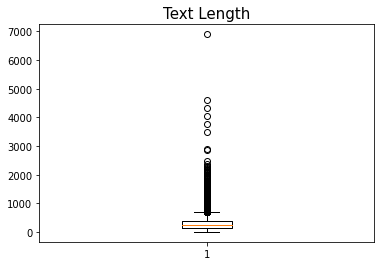

In [ ]:
plt.boxplot(texts_len)
print('25%: ', np.quantile(texts_len, q=0.25))
print('50%: ', np.quantile(texts_len, q=0.5))
print('75%: ', np.quantile(texts_len, q=0.75))
print('85%: ', np.quantile(texts_len, q=0.85))
print('95%: ', np.quantile(texts_len, q=0.95))
plt.title('Text Length', fontsize=15)
plt.show()

- 토큰 길이

In [ ]:
tokens_len = []
for text in tqdm(train_texts):
    inputs = tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=1000,
            pad_to_max_length=True,
            add_special_tokens=True
        )
    inputs = torch.sum(inputs['attention_mask'])
    tokens_len.append(inputs)

  0%|          | 0/16986 [00:00<?, ?it/s]

25%:  64.0
50%:  103.0
75%:  157.0
85%:  197.0
95%:  313.75


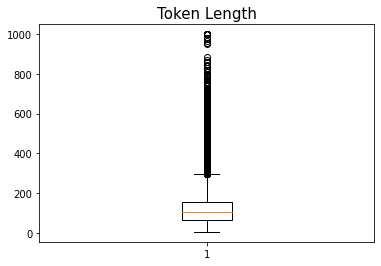

In [ ]:
plt.boxplot(tokens_len)
print('25%: ', np.quantile(tokens_len, q=0.25))
print('50%: ', np.quantile(tokens_len, q=0.5))
print('75%: ', np.quantile(tokens_len, q=0.75))
print('85%: ', np.quantile(tokens_len, q=0.85))
print('95%: ', np.quantile(tokens_len, q=0.95))
plt.title('Token Length', fontsize=15)
plt.show()

### cut text 적용 O

In [ ]:
train_texts = df['overview'].values
train_texts = minor2major(train_texts, minor2major_dict)
train_texts = clean_texts(train_texts)
train_texts = cut_texts(train_texts)
train_texts = remove_fullstops(train_texts)

- 텍스트 길이

In [ ]:
texts_len = list(map(len, train_texts))

25%:  149.0
50%:  245.0
75%:  368.0
85%:  447.0
95%:  515.0


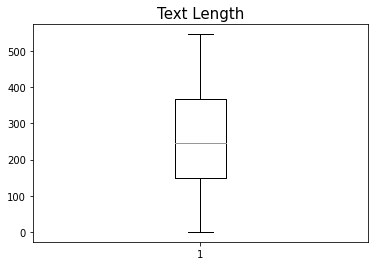

In [ ]:
plt.boxplot(texts_len)
print('25%: ', np.quantile(texts_len, q=0.25))
print('50%: ', np.quantile(texts_len, q=0.5))
print('75%: ', np.quantile(texts_len, q=0.75))
print('85%: ', np.quantile(texts_len, q=0.85))
print('95%: ', np.quantile(texts_len, q=0.95))
plt.title('Text Length', fontsize=15)
plt.show()

- 토큰 길이

In [ ]:
tokens_len = []
for text in tqdm(train_texts):
    inputs = tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=1000,
            pad_to_max_length=True,
            add_special_tokens=True
        )
    inputs = torch.sum(inputs['attention_mask'])
    tokens_len.append(inputs)

  0%|          | 0/16986 [00:00<?, ?it/s]

25%:  63.0
50%:  102.0
75%:  155.0
85%:  190.0
95%:  229.0


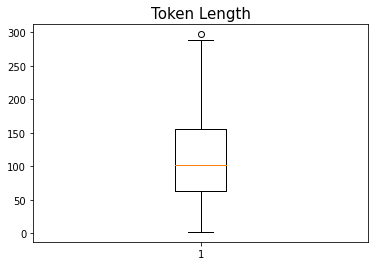

In [ ]:
plt.boxplot(tokens_len)
print('25%: ', np.quantile(tokens_len, q=0.25))
print('50%: ', np.quantile(tokens_len, q=0.5))
print('75%: ', np.quantile(tokens_len, q=0.75))
print('85%: ', np.quantile(tokens_len, q=0.85))
print('95%: ', np.quantile(tokens_len, q=0.95))
plt.title('Token Length', fontsize=15)
plt.show()

## 모델 학습 방법

`1.` 이미지만으로 카테고리를 구분할 수 있다

`2.` 텍스트만으로 카테고리를 구분할 수 있다

`3.` 이미지와 텍스트로 카테고리를 구분할 수 있다

`-` 만약 방법 1 또는 2가 성립한다면 모델을 각각 만들고 앙상블을 통해 예측해도 된다

`-` 만약 오직 방법 3만 성립한다면 이미지와 텍스트를 같이 사용해 모델을 학습시켜야 한다 (예컨대 forward 에서 concat 하든지)

`-` 방법 1은 성립하지 않는 것 같다......

## 모델 학습 준비

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim import Optimizer

import albumentations as A
from albumentations.pytorch import ToTensorV2

# import timm
# from adabelief_pytorch import AdaBelief

from transformers import AdamW
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [21]:
def seed_everything(seed: int = 22) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [22]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 훈련 이미지 불러오기

In [ ]:
# train_images = pd.read_feather('./image-array/train.feather')
# train_images = train_images.to_numpy().T.reshape(-1, 224, 224, 3)
# train_images = train_images[..., ::-1]

- 훈련 텍스트 불러오기

In [23]:
train_texts = df['overview'].values
train_texts = minor2major(train_texts, minor2major_dict)
train_texts = clean_texts(train_texts)
train_texts = cut_texts(train_texts)
train_texts = remove_fullstops(train_texts)

- 데이터 셋과 데이터 로더

In [ ]:
class ImageDataset(Dataset):
    def __init__(
        self,
        images: Sequence[NDArray], 
        labels: Optional[Sequence[int]] = None,
        transforms: Optional[Callable[[A.Compose], Dict[str, Tensor]]] = None
    ) -> None:
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, int], Tensor]:
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용
        image = torch.tensor(image, dtype=torch.float32)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.int64)
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self) -> int:
        return len(self.images)  

In [24]:
class TextDataset(Dataset):
    def __init__(
        self, 
        tokenizer: AutoTokenizer,
        texts: Sequence[NDArray], 
        labels: Optional[Sequence[int]] = None,
        max_len: int = 512
    ) -> None:
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor, int], Tuple[Tensor, Tensor]]:
        text = self.texts[idx]
        inputs = self.tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
        )
        
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        if self.labels is not None:
            label = self.labels[idx]
            return input_ids, attention_mask, label
        return input_ids, attention_mask  ## test는 라벨이 없다

    def __len__(self) -> int:
        return len(self.texts)

In [ ]:
def get_image_dataloader(
        X: Sequence[NDArray], 
        y: Optional[Sequence[int]] = None, 
        transforms: Optional[Callable[[A.Compose], Dict[str, Tensor]]] = None, 
        shuffle_dataloader: bool = True
    ) -> DataLoader:
    dataset = ImageDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

In [25]:
def get_text_dataloader(
        tokenizer: AutoTokenizer, 
        X: Sequence[NDArray],  
        y: Optional[Sequence[int]] = None,
        max_len: int = 512,
        shuffle_dataloader: bool = True
    ) -> DataLoader:
    dataset = TextDataset(tokenizer, X, y, max_len)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 이미지 데이터 변환

In [ ]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(phase: str) -> A.Compose:
    if phase == 'train':
        transforms = A.Compose([
            A.ToFloat(max_value=255),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=25, p=0.5),
            A.RandomGamma(gamma_limit=(90, 110), p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
            ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환  
        ])
    elif phase == 'valid':
        transforms = A.Compose([
            A.ToFloat(max_value=255),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0), 
            ToTensorV2()  
        ])
        
    return transforms  ## 데이터 변환 방식을 반환

- 텍스트 데이터 변환

- 조기 중단

In [26]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
                      'accuracy',
                      'f1_score',
                    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weight', 
        model_name: str = '', 
        current_fold: int = 1
    ) -> None:
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitor (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        ## score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def check_early_stop(self) -> bool:
        return self.early_stop

    def set_fold(self, current_fold: int) -> None:
        self.current_fold = current_fold

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

## 모델 K겹 교차검증

- Kfold와 손실 함수

In [28]:
## ref: https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/25
class FocalLoss(_WeightedLoss):
    def __init__(
        self,
        alpha: float = 0.25,
        gamma: float = 2.0,
        weight: Optional[Tensor] = None,
        label_smoothing: float = 0.0,
        reduction: str = 'mean'
    ) -> None:
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        ce_loss = F.cross_entropy(
            input,
            target,
            weight=self.weight,
            label_smoothing=self.label_smoothing,
            reduction='none'
        )
        p_t = torch.exp(-ce_loss)
        loss = self.alpha * ce_loss * (1 - p_t)**self.gamma

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

In [29]:
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
# loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
loss_fn = FocalLoss(gamma=5.0, label_smoothing=LABEL_SMOOTHING)

- early stopping

In [30]:
early_stopping = EarlyStopping(patience=4,
                               monitor='f1_score',
                               mode='max',
                               path=SAVE_PATH,
                               model_name=MODEL_TYPE,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

- 이미지 

`-` 손절

- 텍스트

In [31]:
def train(
        model: nn.Module,
        dataloader: DataLoader, 
        optimizer: Optimizer, 
        loss_fn: _WeightedLoss, 
        scheduler: Optional[_LRScheduler] = None,
        use_amp: bool = False
    ) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()

    for input_ids, attention_masks, y in tqdm(dataloader):  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        y = y.to(device)
        optimizer.zero_grad()  ## 그래디언트 초기화
        
        if use_amp:
            with torch.cuda.amp.autocast():
                y_hat = model(input_ids, attention_masks)[0]
                loss = loss_fn(y_hat, y)  
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            y_hat = model(input_ids, attention_masks)[0]
            loss = loss_fn(y_hat, y)  
            loss.backward()   ## 미분
            optimizer.step()  ## 업데이트
        train_loss += (loss.item() / len(dataloader)) 
  
        ## 배치마다 학습률 조절
        if scheduler is not None:
            scheduler.step()
        
    return model, train_loss

In [32]:
def evaluate(
        model: nn.Module, 
        dataloader: DataLoader, 
        loss_fn: _WeightedLoss,
        use_amp: bool = False
    ) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 f1 score를 반환"""
    valid_loss, valid_acc, valid_f1 = 0.0, 0.0, 0.0  ## mini-batch 평균 검증 오차와 accuracy, f1 score
    y_list, yhat_list = [], []
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for input_ids, attention_masks, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            y = y.to(device)
            if use_amp:
                with torch.cuda.amp.autocast():
                    y_hat = model(input_ids, attention_masks)[0]
                    loss = loss_fn(y_hat, y)  
            else:
                y_hat = model(input_ids, attention_masks)[0]
                loss = loss_fn(y_hat, y)  

            y_list.extend(y.detach().cpu().numpy().tolist())
            yhat_list.extend(y_hat.argmax(-1).detach().cpu().numpy().tolist())
            valid_loss += loss.item() / len(dataloader)
            
    valid_acc = accuracy_score(y_list, yhat_list)
    valid_f1 = f1_score(y_list, yhat_list, average='weighted')
    return valid_loss, valid_acc, valid_f1

In [35]:
def kfold_cross_validate(
        model: nn.Module, 
        X: Sequence[NDArray], 
        y: Sequence[int], 
        tokenizer: AutoTokenizer,
        skfold: StratifiedKFold, 
        loss_fn: _WeightedLoss, 
        early_stopping: EarlyStopping,
        use_amp: bool = False
    ) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 폴드별 검증 손실을 반환"""
    seed_everything(SEED)  ## 정확한 재현을 위함
    num_folds = skfold.n_splits  ## 폴드의 개수
    fold_valid_loss = []  ## 폴드별 검증 손실
    fold_valid_f1 = []  ## 폴드별 f1 score
    fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 검증 배치 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        if fold < 2:
            continue

        ## 메모리 절약
        clear_gpu()
        
        ## 훈련 데이터와 검증 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]

        ## Dataloader
        train_dataloader = get_text_dataloader(tokenizer, X_train, y_train, MAX_LEN)
        valid_dataloader = get_text_dataloader(tokenizer, X_valid, y_valid, MAX_LEN)

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device))

        ## optimizer
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE) 

        ## scheduler
        t_total = len(train_dataloader) * NUM_EPOCHS  ## The total number of training steps
        warmup_step = int(t_total * 0.1)  ## The number of steps for the warmup phase
        scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 모델 학습
        for epoch in tqdm(range(1, NUM_EPOCHS+1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler, use_amp)  ## 모델 학습
            valid_loss, valid_acc, valid_f1 = evaluate(model, valid_dataloader, loss_fn, use_amp)  ## 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 1 == 0 or epoch == NUM_EPOCHS)  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid acc = {valid_acc:.5f}  valid f1 = {valid_f1:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_f1)  ## __call__ function
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  ## 폴드별 가장 작은 검증 손실
        fold_valid_f1.append(early_stopping.valid_metric_score)  ## 폴드별 가장 작은 검증 손실일 때의 정확도
         
        ## 폴드별 학습 및 검증 종료시 검증 손실과 f1 score를 출력
        print(f'{fold + 1} Fold -> Valid Loss: {early_stopping.valid_loss:.5f} Valid F1 score: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
    ## 폴드별 평균 검증 손실과 평균 f1 score를 출력
    print(f'{num_folds} Fold Mean Valid Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{num_folds} Fold Mean Valid F1 score: {np.mean(fold_valid_f1):.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 모델 선언 및 가중치 저장

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME[MODEL_TYPE], num_labels=NUM_CLASSES)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME[MODEL_TYPE])  
# torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH) 

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of the model checkpoint at kykim/electra-kor-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at kykim/electra-kor-base and are newly initialized: ['classifier.out_proj.weight', 'clas

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

- 모델 K겹 교차검증

`-` 19시 20분 시작

In [36]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, train_texts, target, tokenizer, skfold, loss_fn, early_stopping, use_amp=True)

[1 / 5] Fold Training......
[2 / 5] Fold Training......
[3 / 5] Fold Training......


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.04656  valid loss = 0.81184  valid acc = 0.29261  valid f1 = 0.16384


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  2]  train loss = 0.64356  valid loss = 0.46024  valid acc = 0.56991  valid f1 = 0.46970


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  3]  train loss = 0.36943  valid loss = 0.29244  valid acc = 0.68119  valid f1 = 0.62465


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  4]  train loss = 0.24431  valid loss = 0.23016  valid acc = 0.74713  valid f1 = 0.71127


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  5]  train loss = 0.18026  valid loss = 0.21516  valid acc = 0.76568  valid f1 = 0.74871


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  6]  train loss = 0.13765  valid loss = 0.20173  valid acc = 0.77922  valid f1 = 0.75852


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  7]  train loss = 0.10860  valid loss = 0.19289  valid acc = 0.79129  valid f1 = 0.77694


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  8]  train loss = 0.08711  valid loss = 0.19611  valid acc = 0.79482  valid f1 = 0.78287


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  9]  train loss = 0.07123  valid loss = 0.19775  valid acc = 0.79129  valid f1 = 0.78721


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 10]  train loss = 0.05865  valid loss = 0.20480  valid acc = 0.78628  valid f1 = 0.78113


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 11]  train loss = 0.05024  valid loss = 0.19463  valid acc = 0.79982  valid f1 = 0.79401


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 12]  train loss = 0.04030  valid loss = 0.20520  valid acc = 0.80865  valid f1 = 0.80769


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 13]  train loss = 0.03551  valid loss = 0.20836  valid acc = 0.80748  valid f1 = 0.80424


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 14]  train loss = 0.03089  valid loss = 0.19799  valid acc = 0.81307  valid f1 = 0.81152


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 15]  train loss = 0.02569  valid loss = 0.21464  valid acc = 0.80542  valid f1 = 0.80829


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 16]  train loss = 0.02357  valid loss = 0.20828  valid acc = 0.81660  valid f1 = 0.81370


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 17]  train loss = 0.02098  valid loss = 0.21117  valid acc = 0.81543  valid f1 = 0.81419


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 18]  train loss = 0.01868  valid loss = 0.20948  valid acc = 0.81719  valid f1 = 0.81524


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 19]  train loss = 0.01809  valid loss = 0.20989  valid acc = 0.81749  valid f1 = 0.81569


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 20]  train loss = 0.01759  valid loss = 0.20877  valid acc = 0.82131  valid f1 = 0.82164


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 21]  train loss = 0.01611  valid loss = 0.21023  valid acc = 0.81955  valid f1 = 0.81903


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 22]  train loss = 0.01586  valid loss = 0.21628  valid acc = 0.82043  valid f1 = 0.82013


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 23]  train loss = 0.01536  valid loss = 0.21700  valid acc = 0.82161  valid f1 = 0.82187


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 24]  train loss = 0.01525  valid loss = 0.21852  valid acc = 0.82190  valid f1 = 0.82178


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 25]  train loss = 0.01487  valid loss = 0.21556  valid acc = 0.82337  valid f1 = 0.82281


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 26]  train loss = 0.01465  valid loss = 0.21289  valid acc = 0.82514  valid f1 = 0.82437


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 27]  train loss = 0.01453  valid loss = 0.21436  valid acc = 0.82573  valid f1 = 0.82514


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 28]  train loss = 0.01459  valid loss = 0.21253  valid acc = 0.82573  valid f1 = 0.82489


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 29]  train loss = 0.01439  valid loss = 0.21269  valid acc = 0.82632  valid f1 = 0.82561


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 30]  train loss = 0.01434  valid loss = 0.21270  valid acc = 0.82602  valid f1 = 0.82527
3 Fold -> Best Valid Loss: 0.21269 Valid F1 score: 0.82561

[4 / 5] Fold Training......


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.04554  valid loss = 0.82261  valid acc = 0.29349  valid f1 = 0.17955


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  2]  train loss = 0.64202  valid loss = 0.45189  valid acc = 0.56756  valid f1 = 0.47435


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  3]  train loss = 0.36693  valid loss = 0.28839  valid acc = 0.69090  valid f1 = 0.63582


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  4]  train loss = 0.23931  valid loss = 0.23239  valid acc = 0.74330  valid f1 = 0.70474


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  5]  train loss = 0.17824  valid loss = 0.20540  valid acc = 0.76685  valid f1 = 0.73854


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  6]  train loss = 0.13802  valid loss = 0.19651  valid acc = 0.77981  valid f1 = 0.76191


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  7]  train loss = 0.11025  valid loss = 0.19415  valid acc = 0.79982  valid f1 = 0.78385


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  8]  train loss = 0.09064  valid loss = 0.19814  valid acc = 0.80571  valid f1 = 0.79456


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  9]  train loss = 0.07288  valid loss = 0.19027  valid acc = 0.80983  valid f1 = 0.79995


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 10]  train loss = 0.06051  valid loss = 0.19861  valid acc = 0.80247  valid f1 = 0.79425


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 11]  train loss = 0.04954  valid loss = 0.20582  valid acc = 0.80630  valid f1 = 0.80389


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 12]  train loss = 0.04057  valid loss = 0.19461  valid acc = 0.81984  valid f1 = 0.81729


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 13]  train loss = 0.03441  valid loss = 0.20469  valid acc = 0.80836  valid f1 = 0.80625


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 14]  train loss = 0.03152  valid loss = 0.20039  valid acc = 0.81572  valid f1 = 0.81217


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 15]  train loss = 0.02691  valid loss = 0.20240  valid acc = 0.80983  valid f1 = 0.80803


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 16]  train loss = 0.02330  valid loss = 0.20554  valid acc = 0.81837  valid f1 = 0.81718


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 17]  train loss = 0.02064  valid loss = 0.20847  valid acc = 0.81984  valid f1 = 0.81654
Early Stopping!
4 Fold -> Best Valid Loss: 0.19461 Valid F1 score: 0.81729

[5 / 5] Fold Training......


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.04459  valid loss = 0.81605  valid acc = 0.29232  valid f1 = 0.16736


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  2]  train loss = 0.64124  valid loss = 0.45150  valid acc = 0.57610  valid f1 = 0.47103


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  3]  train loss = 0.36621  valid loss = 0.29702  valid acc = 0.69179  valid f1 = 0.64032


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  4]  train loss = 0.23829  valid loss = 0.23803  valid acc = 0.75007  valid f1 = 0.71681


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  5]  train loss = 0.17398  valid loss = 0.21475  valid acc = 0.76803  valid f1 = 0.73979


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  6]  train loss = 0.13413  valid loss = 0.19878  valid acc = 0.79129  valid f1 = 0.77401


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  7]  train loss = 0.10432  valid loss = 0.21633  valid acc = 0.77951  valid f1 = 0.76479


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  8]  train loss = 0.08474  valid loss = 0.20513  valid acc = 0.79482  valid f1 = 0.78472


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch:  9]  train loss = 0.06672  valid loss = 0.21537  valid acc = 0.79188  valid f1 = 0.78696


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 10]  train loss = 0.05444  valid loss = 0.20702  valid acc = 0.79659  valid f1 = 0.79132


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 11]  train loss = 0.04474  valid loss = 0.21069  valid acc = 0.79806  valid f1 = 0.79254


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 12]  train loss = 0.03797  valid loss = 0.21363  valid acc = 0.79629  valid f1 = 0.79155


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 13]  train loss = 0.03374  valid loss = 0.22294  valid acc = 0.80601  valid f1 = 0.80260


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 14]  train loss = 0.02786  valid loss = 0.21831  valid acc = 0.79982  valid f1 = 0.80120


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 15]  train loss = 0.02406  valid loss = 0.21852  valid acc = 0.80836  valid f1 = 0.80534


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 16]  train loss = 0.02162  valid loss = 0.22467  valid acc = 0.81042  valid f1 = 0.80803


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 17]  train loss = 0.01955  valid loss = 0.21878  valid acc = 0.81984  valid f1 = 0.81679


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 18]  train loss = 0.01833  valid loss = 0.23264  valid acc = 0.81719  valid f1 = 0.81610


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 19]  train loss = 0.01710  valid loss = 0.23042  valid acc = 0.81278  valid f1 = 0.81178


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 20]  train loss = 0.01623  valid loss = 0.23159  valid acc = 0.81160  valid f1 = 0.81136


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 21]  train loss = 0.01572  valid loss = 0.23904  valid acc = 0.80983  valid f1 = 0.81003


  0%|          | 0/213 [00:00<?, ?it/s]

[Epoch: 22]  train loss = 0.01535  valid loss = 0.23135  valid acc = 0.81601  valid f1 = 0.81417
Early Stopping!
5 Fold -> Best Valid Loss: 0.21878 Valid F1 score: 0.81679

5 Fold Mean Valid Best Loss: 0.20869
5 Fold Mean Valid F1 score: 0.81989


- train loss와 valid loss의 변화를 시각화

In [ ]:
def show_loss_plot(
        fold_train_losses: List[List[float]],
        fold_valid_losses: List[List[float]]
    ) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

In [ ]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

## Test 예측

In [37]:
test_texts = test['overview'].values
test_texts = minor2major(test_texts, minor2major_dict)
test_texts = clean_texts(test_texts)
test_texts = cut_texts(test_texts)
test_texts = remove_fullstops(test_texts)

In [38]:
def predict(
        model: nn.Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        return_prob: bool = False
    ) -> Tensor:
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight_path in tqdm(weight_path_list):
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()
        
        with torch.no_grad(): 
            for input_ids, attention_masks in dataloader:  ## test 데이터는 라벨(y)이 없다
                input_ids = input_ids.to(device) 
                attention_masks = attention_masks.to(device) 
                y_hat = model(input_ids, attention_masks)[0].cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])

        test_probs += (probs / NUM_FOLDS) 
    test_probs = torch.softmax(torch.from_numpy(test_probs), dim=-1)  ## 각 컬럼별 확률
    _, test_preds = torch.max(test_probs, dim=-1)  ## 최댓값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [39]:
test_dataloader = get_text_dataloader(tokenizer=tokenizer, X=test_texts, y=None, max_len=MAX_LEN, shuffle_dataloader=False)

In [40]:
preds = predict(model, test_dataloader, SAVE_PATH, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
submission['cat3'] = le.inverse_transform(preds)
submission.head()

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,수련시설
4,TEST_00004,산


In [42]:
# submission.to_csv(f'submission-{MODEL_TYPE}-6.csv', index=False)